In [33]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_colwidth', -1)
from time import time
import re
import string
import os
import emoji
from pprint import pprint
import collections
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)
from sklearn.metrics import roc_auc_score ,mean_squared_error,accuracy_score,classification_report,confusion_matrix,roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.svm import SVC  
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.feature_extraction.text import HashingVectorizer, TfidfVectorizer, CountVectorizer
# from sklearn.externals import joblib
# import gensim
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import warnings
warnings.filterwarnings('ignore')
np.random.seed(37)

In [13]:
#Loading the Train data
def load_train():
    df = pd.read_csv('data/train.csv')
    df = df[['tweet', 'sentiment']]
    df = df.dropna()
#     print(df.info())
    return df

df = load_train()
df.head()

,tweet,sentiment
0,#sxswnui #sxsw #apple defining language of touch with different dialects becoming smaller,1
1,"Learning ab Google doodles! All doodles should be light, funny &amp; innovative, with exceptions for significant occasions. #GoogleDoodle #sxsw",1
2,"one of the most in-your-face ex. of stealing the show in yrs RT @mention &quot;At #SXSW, Apple schools the mkt experts&quot; {link}",2
3,This iPhone #SXSW app would b pretty awesome if it didn't crash every 10mins during extended browsing. #Fuckit #Illmakeitwork,0
4,Line outside the Apple store in Austin waiting for the new iPad #SXSW {link},1


In [5]:
df.shape

(7273, 2)

In [14]:
#Loading the Train data
def load_test():
    df = pd.read_csv('data/test.csv')
    df = df[['tweet_id','tweet']]
#     print(df.info())
    return df

dftest = load_test()
df1 = dftest[['tweet']]
df1.head()

,tweet
0,"Audience Q: What prototyping tools do you use? Sketchbooks/sharpie pens, photoshop, Balsamic, Google docs, Axsure, etc. #myprototype #sxsw"
1,At SXSW? Send Your Best Photos &amp; Videos to... {link} #citizen_journalism #cnn #ireport #photography #sxsw #Cyber #iPhone
2,@mention and here's a pic of you winning your ipad! #unsix #sxsw cc @mention @mention {link} (cont) {link}
3,Google Marissa Mayer: mobile phone as a cursor of physical location - new version of map fast and more real life like #sxsw
4,#SXSW Google maps is even cooler than I thought


In [15]:
dftest.shape

(1819, 2)

In [16]:
class TextCounts(BaseEstimator, TransformerMixin):
    
    def count_regex(self, pattern, tweet):
        return len(re.findall(pattern, tweet))
    
    def fit(self, X, y=None, **fit_params):
        # fit method is used when specific operations need to be done on the train data, but not on the test data
        return self

    def transform(self, X, **transform_params):
        def has_long(sentence):
            a = []
            for x in sentence.split():
                if re.compile("([a-zA-Z])\\1{2,}").search(x):
                    a.append(x)
            return a
        def isalpha(stre):
            countl=0
            for i in stre:
                if i.isalpha():
                    countl+=1
            return countl
        def isdig(stre):
            countn=0
            for i in stre:
                if i.isdigit():
                    countn+=1
            return countn
        fstcap = X.apply(lambda a:len([''.join(c) for c in a.strip().split() if c[0].isupper()])) # list of first capital letter
        elgwrd = X.apply(lambda a:len(has_long(a))) # list of Elongated word e.g. boooom
        NofChr = X.apply(lambda a:isalpha(a)) # number of character
        Nofdgt = X.apply(lambda a:isdig(a)) # number of digit
        count_words = X.apply(lambda x: self.count_regex(r'\w+', str(x)))   # count word 
        count_mentions = X.apply(lambda x: self.count_regex(r'@\w+', str(x)))  # count mentions
        count_hashtags = X.apply(lambda x: self.count_regex(r'#\w+', str(x)))  # count hashtags
        count_capital_words = X.apply(lambda x: self.count_regex(r'\b[A-Z]{2,}\b', str(x)))   # count uppercase words
        count_excl_quest_marks = X.apply(lambda x: self.count_regex(r'!|\?', str(x)))     # count exclametory mark
        count_urls = X.apply(lambda x: self.count_regex(r'http.?://[^\s]+[\s]?', str(x)))  # count urls
        # We will replace the emoji symbols with a description, which makes using a regex for counting easier
        # Moreover, it will result in having more words in the tweet
        count_emojis = X.apply(lambda x: emoji.demojize(str(x))).apply(lambda x: self.count_regex(r':[a-z_&]+:', str(x)))
        
        df = pd.DataFrame({'count_words': count_words
                           , 'count_char': NofChr
                           , 'count_digit': Nofdgt
                           , 'count_mentions': count_mentions
                           , 'count_hashtags': count_hashtags
                           , 'count_capital_words': count_capital_words
                           , 'count_fCap': fstcap
                           , 'count_Elgwords': elgwrd
                           , 'count_excl_quest_marks': count_excl_quest_marks
                           , 'count_urls': count_urls
                           , 'count_emojis': count_emojis
                          })
        
        return df


In [17]:
class CleanText(BaseEstimator, TransformerMixin):
    def remove_mentions(self, input_text):
        return re.sub(r'@\w+', '', str(input_text))
    
    def remove_urls(self, input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', str(input_text))
    
    def emoji_oneword(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        return input_text.replace('_','')
    
    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)
    def remove_digits(self, input_text):
        return re.sub('\d+', '', str(input_text))
    
    def to_lower(self, input_text):
        return input_text.lower()
    
    def remove_stopwords(self, input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
    def stemming(self, input_text):
        porter = PorterStemmer()
        words = input_text.split() 
        stemmed_words = [porter.stem(word) for word in words]
        return " ".join(stemmed_words)
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.emoji_oneword).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(self.remove_stopwords).apply(self.stemming)
        return clean_X

In [18]:
df = load_train()  # load train data
df1 = load_test() # load test data

# create numerical feature for train
tc = TextCounts()
df_train = tc.fit_transform(df.tweet)
df_train['sentiment'] = df.sentiment
# create numerical feature for test
df_test = tc.fit_transform(df1['tweet'])
# clean text for train and CountVectorizer train data
ct = CleanText()
train_clean = ct.fit_transform(df['tweet'])
# clean text for test and CountVectorizer test data
ct = CleanText()
test_clean = ct.fit_transform(df1['tweet'])

df_model = df_train
df_model['clean_text'] = train_clean
df1_model = df_test
df1_model['clean_text'] = test_clean


Descriptive stats for count_words
---------------------------------
            count       mean       std  min   25%   50%   75%   max
sentiment                                                          
0          456.0   19.500000  5.405736  6.0  16.0  20.0  24.0  32.0
1          4310.0  18.045012  5.223198  2.0  14.0  18.0  22.0  41.0
2          2382.0  18.863980  5.289912  4.0  15.0  19.0  23.0  35.0
3          125.0   18.152000  5.296158  8.0  14.0  18.0  22.0  30.0


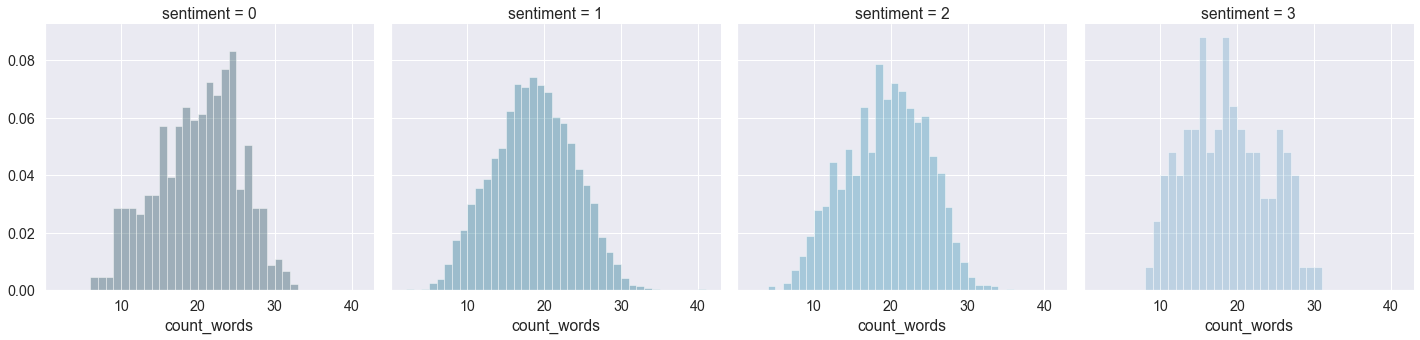

Descriptive stats for count_mentions
------------------------------------
            count      mean       std  min  25%  50%  75%  max
sentiment                                                     
0          456.0   0.552632  0.739374  0.0  0.0  0.0  1.0  4.0
1          4310.0  0.850348  0.976455  0.0  0.0  1.0  1.0  8.0
2          2382.0  0.740134  0.838025  0.0  0.0  1.0  1.0  5.0
3          125.0   0.640000  0.962188  0.0  0.0  0.0  1.0  5.0


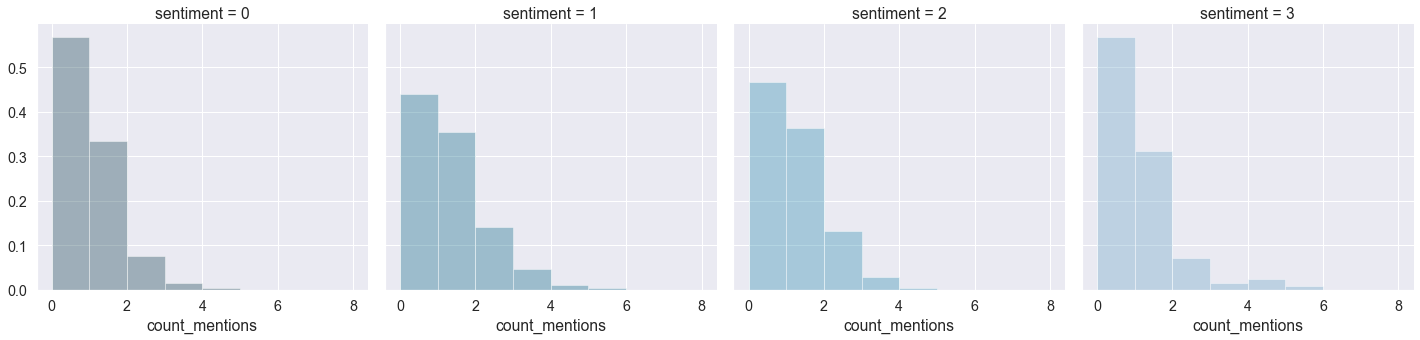

Descriptive stats for count_hashtags
------------------------------------
            count      mean       std  min  25%  50%  75%   max
sentiment                                                      
0          456.0   1.605263  0.839868  1.0  1.0  1.0  2.0  6.0 
1          4310.0  1.792575  1.180463  0.0  1.0  1.0  2.0  12.0
2          2382.0  1.683039  0.952835  0.0  1.0  1.0  2.0  7.0 
3          125.0   1.600000  0.950382  1.0  1.0  1.0  2.0  5.0 


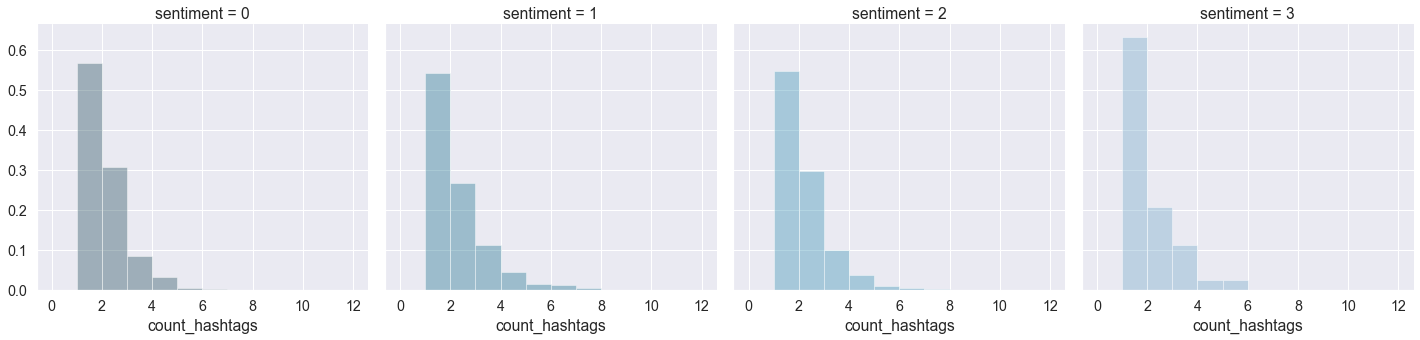

Descriptive stats for count_capital_words
-----------------------------------------
            count      mean       std  min  25%  50%  75%   max
sentiment                                                      
0          456.0   0.901316  1.199413  0.0  0.0  1.0  1.0  18.0
1          4310.0  1.110209  1.060554  0.0  0.0  1.0  2.0  17.0
2          2382.0  1.033165  0.963940  0.0  0.0  1.0  2.0  6.0 
3          125.0   0.976000  0.919888  0.0  0.0  1.0  1.0  4.0 


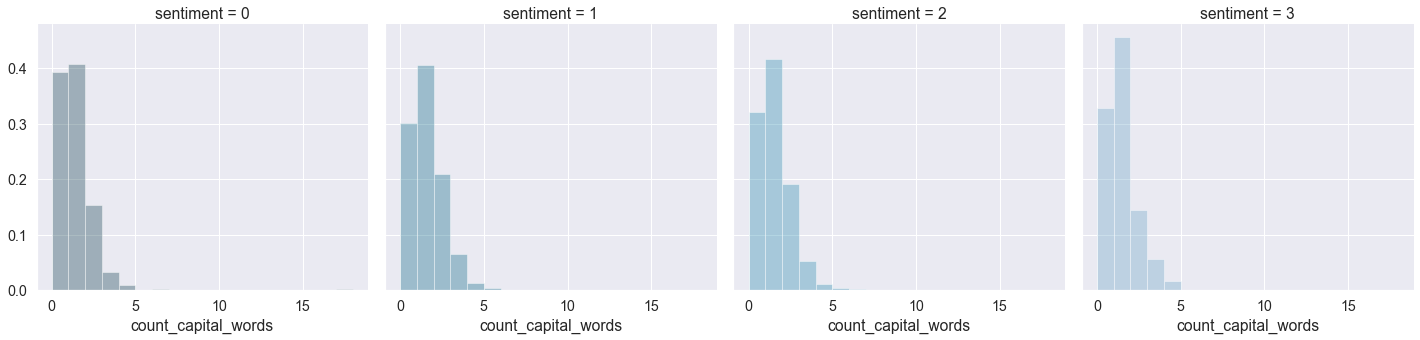

Descriptive stats for count_excl_quest_marks
--------------------------------------------
            count      mean       std  min  25%  50%  75%   max
sentiment                                                      
0          456.0   0.361842  0.819134  0.0  0.0  0.0  0.0  8.0 
1          4310.0  0.406265  0.767710  0.0  0.0  0.0  1.0  11.0
2          2382.0  0.548699  0.903084  0.0  0.0  0.0  1.0  9.0 
3          125.0   0.424000  0.825638  0.0  0.0  0.0  1.0  3.0 


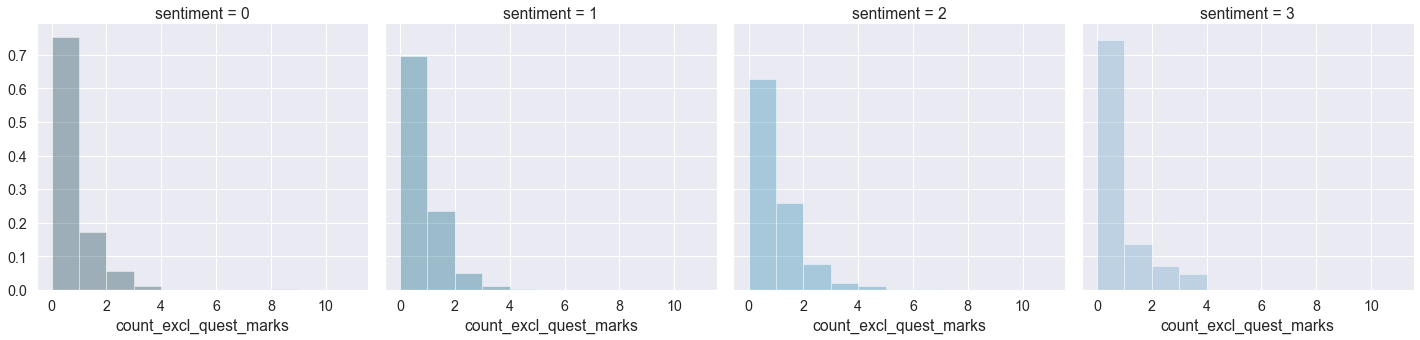

Descriptive stats for count_urls
--------------------------------
            count      mean       std  min  25%  50%  75%  max
sentiment                                                     
0          456.0   0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
1          4310.0  0.001624  0.040272  0.0  0.0  0.0  0.0  1.0
2          2382.0  0.004618  0.067813  0.0  0.0  0.0  0.0  1.0
3          125.0   0.000000  0.000000  0.0  0.0  0.0  0.0  0.0


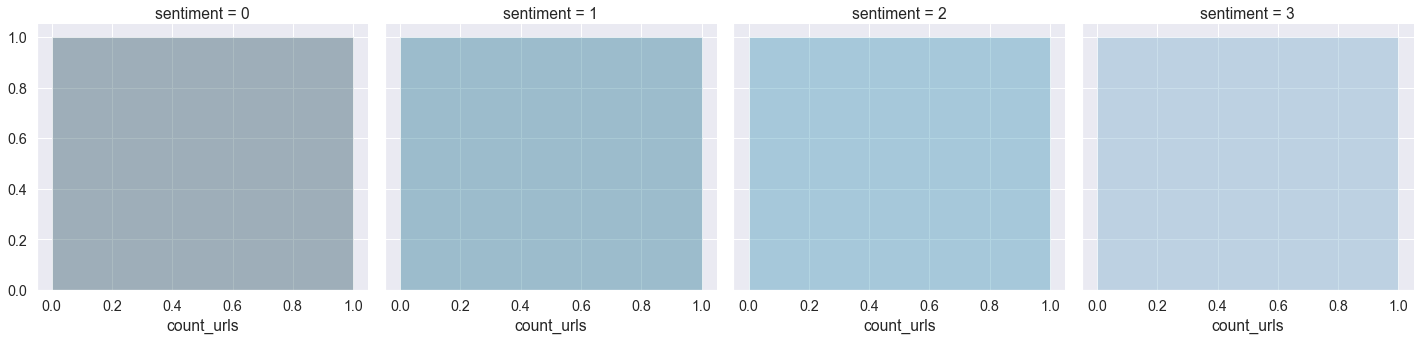

Descriptive stats for count_emojis
----------------------------------
            count      mean       std  min  25%  50%  75%  max
sentiment                                                     
0          456.0   0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
1          4310.0  0.001624  0.040272  0.0  0.0  0.0  0.0  1.0
2          2382.0  0.001259  0.035474  0.0  0.0  0.0  0.0  1.0
3          125.0   0.000000  0.000000  0.0  0.0  0.0  0.0  0.0


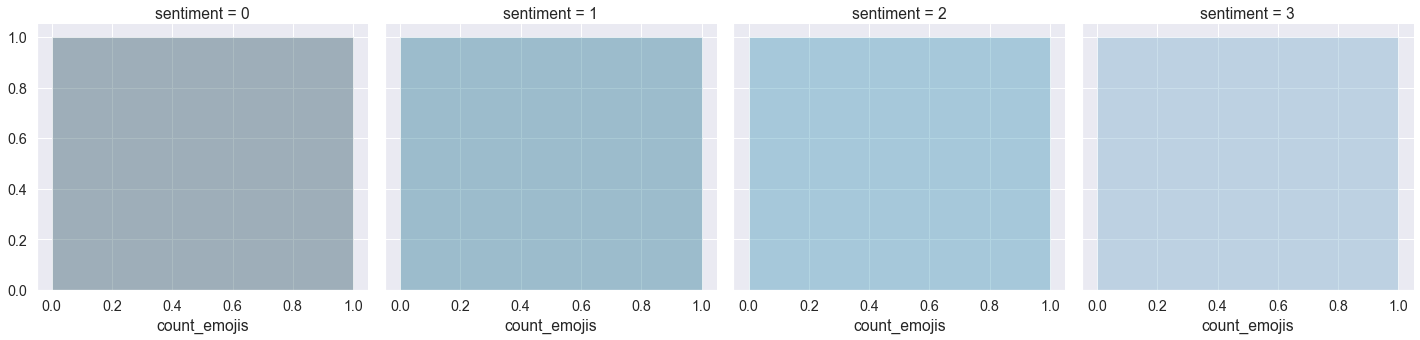

In [19]:
def show_dist(df, col):
    print('Descriptive stats for {}'.format(col))
    print('-'*(len(col)+22))
    print(df.groupby('sentiment')[col].describe())
    bins = np.arange(df[col].min(), df[col].max() + 1)
    g = sns.FacetGrid(df, col='sentiment', size=5, hue='sentiment', palette="PuBuGn_d")
    g = g.map(sns.distplot, col, kde=False, norm_hist=True, bins=bins)
    plt.show()
    
df_eda = df_model
show_dist(df_eda, 'count_words')
show_dist(df_eda, 'count_mentions')
show_dist(df_eda, 'count_hashtags')
show_dist(df_eda, 'count_capital_words')
show_dist(df_eda, 'count_excl_quest_marks')
show_dist(df_eda, 'count_urls')
show_dist(df_eda, 'count_emojis')

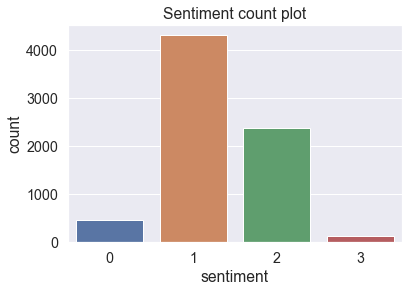

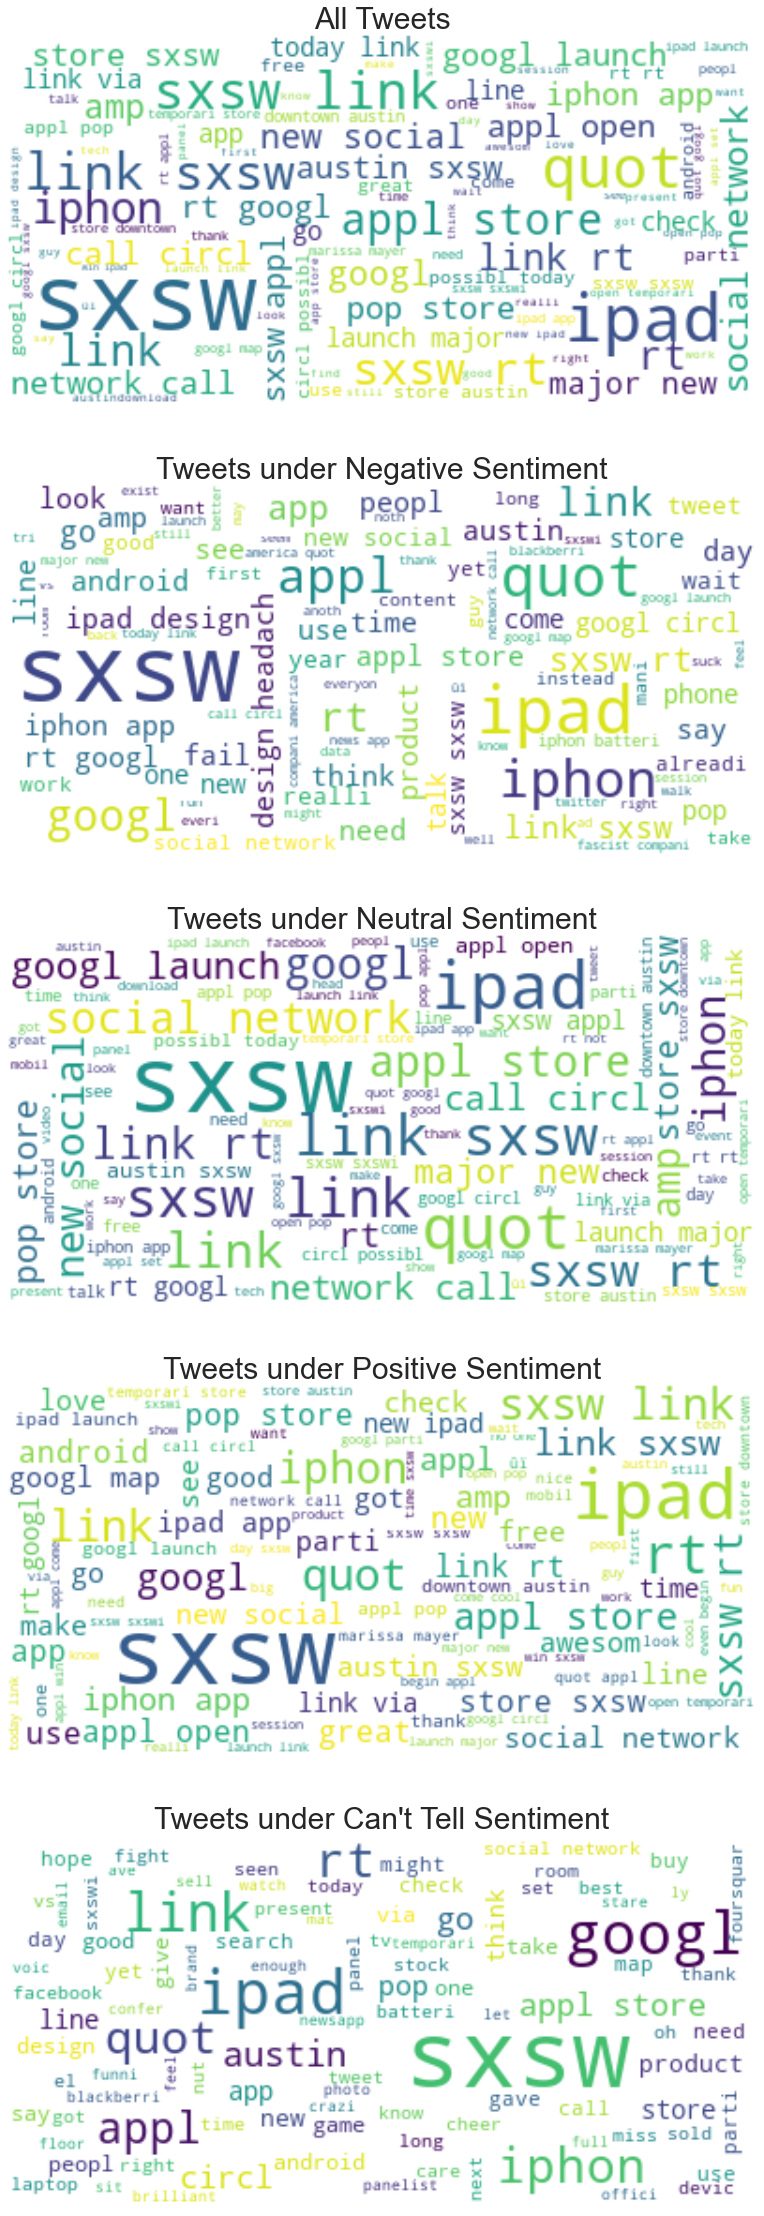

In [24]:
# create countplot for Target column   Anaji 12:15pm 16 march
def createCP(df,x1):
    sns.countplot(x = x1, data = df)
    plt.title('Sentiment count plot')
    plt.savefig('Sentiment count plot.png')
    plt.show()

x = df.columns.tolist()[-1]   # last column is Target 'sentiment''
createCP(df, x)

# function for wordcloud 
def createWC(df):
    tweet_all = " ".join(i for i in df.tweet)
    tweet_0 = " ".join(i for i in df[df['sentiment']==0].tweet)
    tweet_1 = " ".join(i for i in df[df['sentiment']==1].tweet)
    tweet_2 = " ".join(i for i in df[df['sentiment']==2].tweet)
    tweet_3 = " ".join(i for i in df[df['sentiment']==3].tweet)

    fig, ax = plt.subplots(5, 1, figsize  = (40,40))
    # Create and generate a word cloud image:
    wc_all = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(tweet_all)
    wc_0 = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(tweet_0)
    wc_1 = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(tweet_1)
    wc_2 = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(tweet_2)
    wc_3 = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(tweet_3)

    # 0: Negative,  1: Neutral, 2: Positive, 3: Can't Tell
    # Display the generated image:

    ax[0].imshow(wc_all, interpolation='bilinear')
    ax[0].set_title('All Tweets', fontsize=30)
    ax[0].axis('off')
    wc_all.to_file('wc_all.png')
    ax[1].imshow(wc_0, interpolation='bilinear')
    ax[1].set_title('Tweets under Negative Sentiment',fontsize=30)
    ax[1].axis('off')
    wc_0.to_file('wc_0.png')
    ax[2].imshow(wc_1, interpolation='bilinear')
    ax[2].set_title('Tweets under Neutral Sentiment',fontsize=30)
    ax[2].axis('off')
    wc_1.to_file('wc_1.png')
    ax[3].imshow(wc_2, interpolation='bilinear')
    ax[3].set_title('Tweets under Positive Sentiment',fontsize=30)
    ax[3].axis('off')
    wc_2.to_file('wc_2.png')
    ax[4].imshow(wc_3, interpolation='bilinear')
    ax[4].set_title('Tweets under Can\'t Tell Sentiment',fontsize=30)
    ax[4].axis('off')
    wc_3.to_file('wc_3.png')

df_model['tweet'] = df_model['clean_text']  
createWC(df_model)

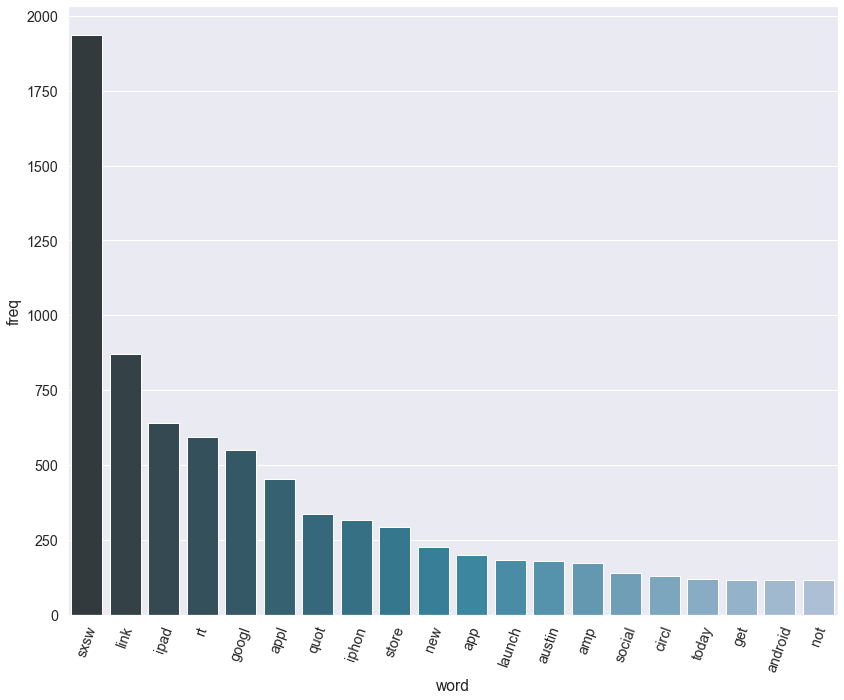

In [27]:
# CountVectorizer Classifier
cv = CountVectorizer()
bow = cv.fit_transform(test_clean)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])
fig, ax = plt.subplots(figsize=(12, 10))
sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.xticks(rotation=70)
plt.tight_layout()
plt.savefig('CountVectorizer.png')
plt.show()


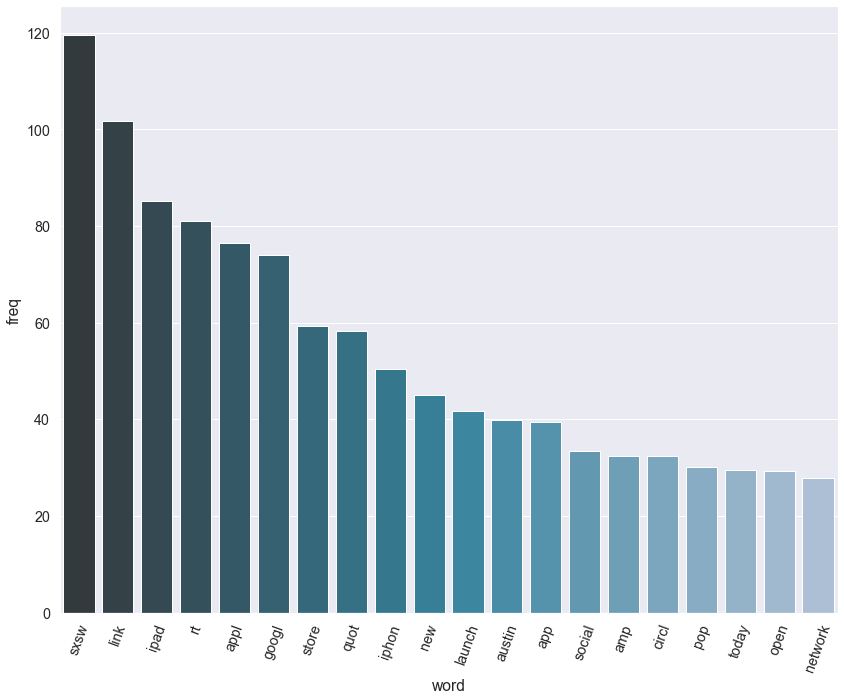

In [28]:
# TfidfVectorizer Classifier
cv = TfidfVectorizer()
bow = cv.fit_transform(test_clean)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])
fig, ax = plt.subplots(figsize=(12, 10))
sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.xticks(rotation=70)
plt.tight_layout()
plt.savefig('TfidfVectorizer.png')
plt.show()

In [38]:
df_model.head()

,count_words,count_char,count_digit,count_mentions,count_hashtags,count_capital_words,count_fCap,count_Elgwords,count_excl_quest_marks,count_urls,count_emojis,sentiment,clean_text,tweet
0,12,75,0,0,3,0,0,0,0,0,0,1,sxswnui sxsw appl defin languag touch differ dialect becom smaller,sxswnui sxsw appl defin languag touch differ dialect becom smaller
1,19,117,0,0,2,0,3,0,1,0,0,1,learn ab googl doodl doodl light funni amp innov except signific occas googledoodl sxsw,learn ab googl doodl doodl light funni amp innov except signific occas googledoodl sxsw
2,26,98,0,1,1,2,2,0,0,0,0,2,one face ex steal show yr rt quot sxsw appl school mkt expert quot link,one face ex steal show yr rt quot sxsw appl school mkt expert quot link
3,20,100,2,0,3,1,1,0,0,0,0,0,iphon sxsw app would pretti awesom crash everi min extend brows fuckit illmakeitwork,iphon sxsw app would pretti awesom crash everi min extend brows fuckit illmakeitwork
4,14,60,0,0,1,1,3,0,0,0,0,1,line outsid appl store austin wait new ipad sxsw link,line outsid appl store austin wait new ipad sxsw link


In [39]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7273 entries, 0 to 7273
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   count_words             7273 non-null   int64 
 1   count_char              7273 non-null   int64 
 2   count_digit             7273 non-null   int64 
 3   count_mentions          7273 non-null   int64 
 4   count_hashtags          7273 non-null   int64 
 5   count_capital_words     7273 non-null   int64 
 6   count_fCap              7273 non-null   int64 
 7   count_Elgwords          7273 non-null   int64 
 8   count_excl_quest_marks  7273 non-null   int64 
 9   count_urls              7273 non-null   int64 
 10  count_emojis            7273 non-null   int64 
 11  sentiment               7273 non-null   int64 
 12  clean_text              7273 non-null   object
 13  tweet                   7273 non-null   object
dtypes: int64(12), object(2)
memory usage: 1.1+ MB


In [30]:
tweet_0 = " ".join(i for i in df[df['sentiment']==0].tweet)
tweet_0

"This iPhone #SXSW app would b pretty awesome if it didn't crash every 10mins during extended browsing. #Fuckit #Illmakeitwork .@mention I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW. So I went the whole day w/out my laptop &amp; just used my iPad 1. Things I missed: FTP, cloudapp, fast typing, &amp; skype. #iPad #sxsw RT @mention 'Google lost its way by caring too much for the business vs. the users' - @mention #psych #sxsw I composed a tweet so acerbic and cynical about ipad users that my phone crashed and dumped all my apps. #twitterpower #sxsw #imthatgood @mention is about to talk about the mistakes he made building Netflix for the iPhone. #SXSW #netflixiphone You spent $1,000+ to come to SXSW. \r\n\r\nYou've already used iPad 1. \r\n\r\nThe wait is a couple city blocks. \r\n\r\nWhy? #ipad2 #SXSW {link} My tweeting from #sxsw been pretty non existent today thanks to the @mention iPhone app #fail - Hootsuite is th

In [34]:
def hashtag_extract(x):
    hashtags = []
    
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags
# extracting hashtags from  tweets
HT_negative = hashtag_extract(df['tweet'][df['sentiment'] == 0])
HT_neutral = hashtag_extract(df['tweet'][df['sentiment'] == 1])
HT_positive = hashtag_extract(df['tweet'][df['sentiment'] == 2])
HT_cantell = hashtag_extract(df['tweet'][df['sentiment'] == 3])



# unnesting list
HT_neutral = sum(HT_neutral,[])
HT_negative = sum(HT_negative,[])
HT_positive = sum(HT_positive,[])
HT_cantell = sum(HT_cantell,[])

In [42]:
HT = [HT_neutral,HT_negative, HT_positive, HT_cantell]

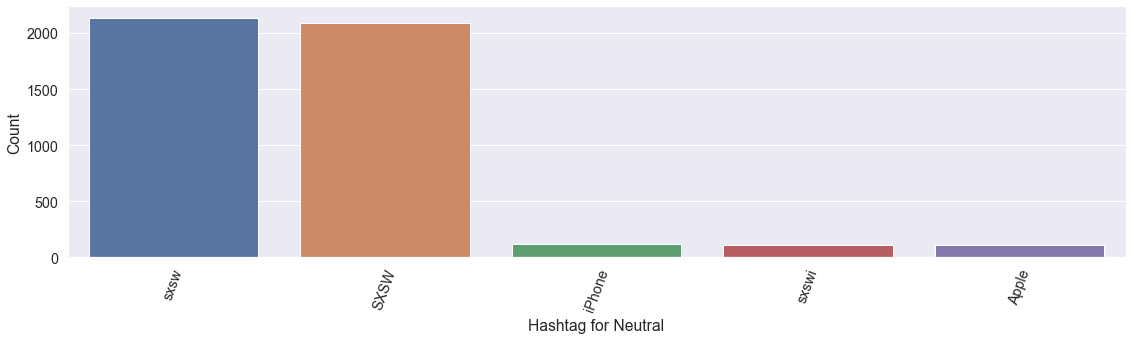

In [49]:
import nltk 

a = nltk.FreqDist(HT_neutral)
d = pd.DataFrame({'Hashtag for Neutral': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 5 most frequent hashtags     
d = d.nlargest(columns="Count", n = 5) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag for Neutral", y = "Count")
ax.set(ylabel = 'Count')
# plt.title(i)
plt.xticks(rotation=70)
plt.tight_layout()
plt.savefig('HT_neutral.png')
plt.show()

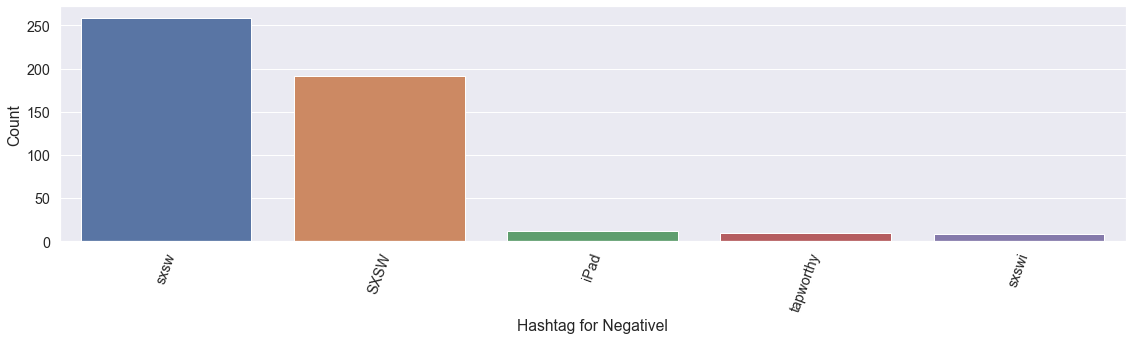

In [50]:
import nltk 

a = nltk.FreqDist(HT_negative)
d = pd.DataFrame({'Hashtag for Negativel': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 5 most frequent hashtags     
d = d.nlargest(columns="Count", n = 5) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag for Negativel", y = "Count")
ax.set(ylabel = 'Count')
# plt.title(i)
plt.xticks(rotation=70)
plt.tight_layout()
plt.savefig('HT_negative.png')
plt.show()

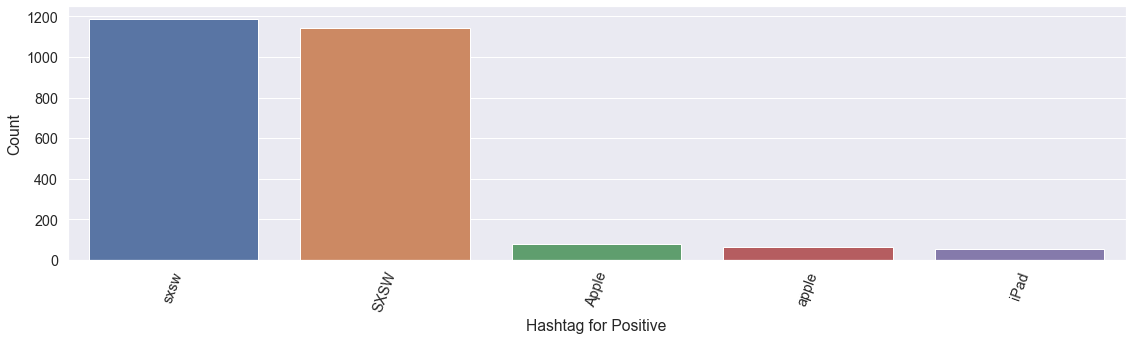

In [51]:
import nltk 

a = nltk.FreqDist(HT_positive)
d = pd.DataFrame({'Hashtag for Positive': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 5 most frequent hashtags     
d = d.nlargest(columns="Count", n = 5) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag for Positive", y = "Count")
ax.set(ylabel = 'Count')
# plt.title(i)
plt.xticks(rotation=70)
plt.tight_layout()
plt.savefig('HT_positive.png')
plt.show()

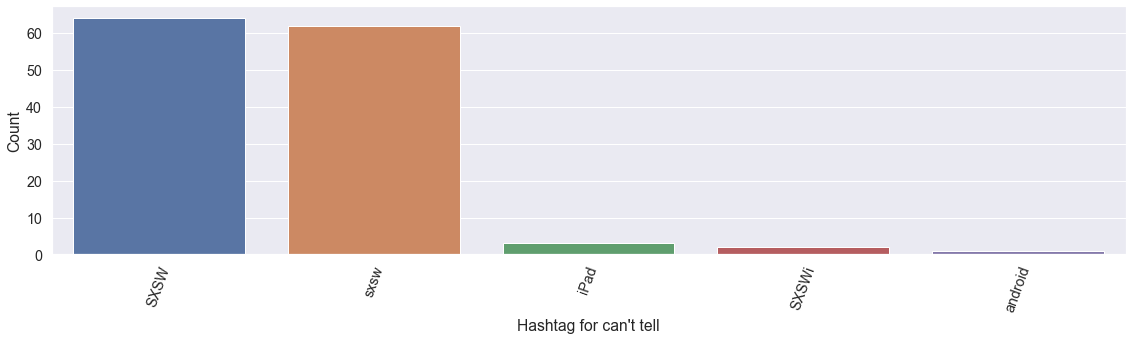

In [52]:
import nltk 

a = nltk.FreqDist(HT_cantell)
d = pd.DataFrame({'Hashtag for can\'t tell': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 5 most frequent hashtags     
d = d.nlargest(columns="Count", n = 5) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag for can\'t tell", y = "Count")
ax.set(ylabel = 'Count')
# plt.title(i)
plt.xticks(rotation=70)
plt.tight_layout()
plt.savefig('HT_cantell.png')
plt.show()

In [57]:
X = df_model['clean_text']
X1 = df1_model['clean_text']
y = df_model.sentiment
vector = CountVectorizer(stop_words = 'english')  # CountVectorizer
Xc = vector.fit_transform(X)     


f1 = []
def run_model(predictors,target, model):
    X_train, X_test, y_train, y_test = train_test_split(predictors, target, test_size=0.2, random_state=6)
    model.fit(X_train, y_train)
    y_scores = model.predict(X_test)
#     print('Train Accuracy:\n',model.score(X_train,y_train))
#     print('Validation Accuracy:\n',model.score(X_test,y_test))
#     print('Classification Report:\n',classification_report(y_test, y_scores))
    print("Precision Score : ",precision_score(y_test, y_scores,average='micro'))
    print("Recall Score : ",recall_score(y_test, y_scores,average='micro'))

    # calculating the f1 score for the validation set
    print("F1 score :", f1_score(y_test, y_scores,average='micro'))
    f1.append(f1_score(y_test, y_scores,average='micro'))
    print("="*120)
    return f1


# Predictors
X = Xc
y = df_model['sentiment']

models = {'Logistic Regression':LogisticRegression()
          ,'Decision Tree':DecisionTreeClassifier()
          ,'Random Forest': RandomForestClassifier()
          ,'MNB':MultinomialNB()
          ,'SVC':SVC(kernel='linear', gamma = 6, random_state=0)}

j = 0
print('='*40+"  CountVectorizer Classifier  "+'='*40)
for i in models.items():
    print('='*50,list(models.keys())[j],'='*50)
    model = i[1]
    a = run_model(X, y, model)
    j=j+1
print('Max f1_score is {} in model {}'.format(max(a),list(models.keys())[a.index(max(a))]))

========================================  CountVectorizer Classifier  ========================================
================================================== Logistic Regression ==================================================
Precision Score :  0.6769759450171822
Recall Score :  0.6769759450171822
F1 score : 0.6769759450171822
================================================== Decision Tree ==================================================
Precision Score :  0.6233676975945017
Recall Score :  0.6233676975945017
F1 score : 0.6233676975945017
================================================== Random Forest ==================================================
Precision Score :  0.6659793814432989
Recall Score :  0.6659793814432989
F1 score : 0.6659793814432989
================================================== MNB ==================================================
Precision Score :  0.6474226804123712
Recall Score :  0.6474226804123712
F1 score : 0.6474226804123712
=================

In [58]:
X = df_model['clean_text']
X1 = df1_model['clean_text']
y = df_model.sentiment
tfidf = TfidfVectorizer(stop_words = 'english')  #TF-IDF Vectoriser
Xt = tfidf.fit_transform(X)

f1 = []
def run_model(predictors,target, model):
    X_train, X_test, y_train, y_test = train_test_split(predictors, target, test_size=0.2, random_state=6)
    model.fit(X_train, y_train)
    y_scores = model.predict(X_test)
#     print('Train Accuracy:\n',model.score(X_train,y_train))
#     print('Validation Accuracy:\n',model.score(X_test,y_test))
#     print('Classification Report:\n',classification_report(y_test, y_scores))
    print("Precision Score : ",precision_score(y_test, y_scores,average='micro'))
    print("Recall Score : ",recall_score(y_test, y_scores,average='micro'))

    # calculating the f1 score for the validation set
    print("F1 score :", f1_score(y_test, y_scores,average='micro'))
    f1.append(f1_score(y_test, y_scores,average='micro'))
    print("="*120)
    return f1


# Predictors
X = Xt
y = df_model['sentiment']

models = {'Logistic Regression':LogisticRegression()
          ,'Decision Tree':DecisionTreeClassifier()
          ,'Random Forest': RandomForestClassifier()
          ,'MNB':MultinomialNB()
          ,'SVC':SVC(kernel='linear', gamma = 6, random_state=0)}

j = 0
print('='*40+"  TfidfVectorizer Classifier  "+'='*40)
for i in models.items():
    print('='*50,list(models.keys())[j],'='*50)
    model = i[1]
    a = run_model(X, y, model)
    j=j+1
print('Max f1_score is {} in model {}'.format(max(a),list(models.keys())[a.index(max(a))]))

========================================  TfidfVectorizer Classifier  ========================================
================================================== Logistic Regression ==================================================
Precision Score :  0.6776632302405499
Recall Score :  0.6776632302405499
F1 score : 0.6776632302405499
================================================== Decision Tree ==================================================
Precision Score :  0.5986254295532646
Recall Score :  0.5986254295532646
F1 score : 0.5986254295532646
================================================== Random Forest ==================================================
Precision Score :  0.6639175257731958
Recall Score :  0.6639175257731958
F1 score : 0.6639175257731958
================================================== MNB ==================================================
Precision Score :  0.6343642611683848
Recall Score :  0.6343642611683848
F1 score : 0.6343642611683848
=================

In [14]:
X = df_model['clean_text']
X1 = df1_model['clean_text']
tfidf = TfidfVectorizer(stop_words = 'english')  #TF-IDF Vectoriser
Xt = tfidf.fit_transform(X)

df_test = df1_model['clean_text']
df_test1 = tfidf.transform(df_test)

def LogReg(X,y):
    global model
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=6)
    model = SVC(kernel='linear', gamma = 6, random_state=0)   # SVC Model
    model.fit(X_train, y_train)
    y_score = model.predict(X_test)
    f1 = f1_score(y_test, y_score,average='micro')
    
    return f1

#trainning
X = Xt
y = df_model.sentiment
f1 = LogReg(X,y)    
print('f1 score is:',f1)

#testing function
def prediction(test):
    y_pred = model.predict(test)
    return y_pred

# Storing the Id column
Id = df1[['tweet_id']]

#predicting on test file
y_pred = pd.DataFrame(prediction(df_test1),columns=['sentiment']) 
print(y_pred['sentiment'].value_counts())
submission = pd.concat([Id,y_pred['sentiment']],1)
submission.head()
# submission.to_csv('submission.csv',index=False)

f1 score is: 0.6714776632302405
1    1365
2    428 
0    26  
Name: sentiment, dtype: int64


,tweet_id,sentiment
0,7506,1
1,7992,1
2,247,1
3,7688,2
4,3294,2


In [11]:
X = df_model['clean_text']
X1 = df1_model['clean_text']
tfidf = TfidfVectorizer(stop_words = 'english')  #TF-IDF Vectoriser
Xt = tfidf.fit_transform(X)

df_test = df1_model['clean_text']
df_test1 = tfidf.transform(df_test)

def LogReg(X,y):
    global model
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=6)
    model = LogisticRegression()        # LogisticRegression Model
    model.fit(X_train, y_train)
    y_score = model.predict(X_test)
    f1 = f1_score(y_test, y_score,average='micro')
    
    return f1

#trainning
X = Xt
y = df_model.sentiment
f1 = LogReg(X,y)    
print('f1 score is:',f1)

#testing function
def prediction(test):
    y_pred = model.predict(test)
    return y_pred

# Storing the Id column
Id = df1[['tweet_id']]

#predicting on test file
y_pred = pd.DataFrame(prediction(df_test1),columns=['sentiment']) 
print(y_pred['sentiment'].value_counts())
submission = pd.concat([Id,y_pred['sentiment']],1)
submission.head()
# submission.to_csv('submission.csv',index=False)

f1 score is: 0.6701030927835051
1    1420
2    391 
0    8   
Name: sentiment, dtype: int64


,tweet_id,sentiment
0,7506,1
1,7992,1
2,247,1
3,7688,2
4,3294,2


In [12]:
X = df_model['clean_text']
X1 = df1_model['clean_text']
CV = CountVectorizer(stop_words = 'english')   # CountVectorizer()
Xc = CV.fit_transform(X)

df_test = df1_model['clean_text']
df_test1 = CV.transform(df_test)

def LogReg(X,y):
    global model
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=6)
    model = LogisticRegression()       # LogisticRegression Model
    model.fit(X_train, y_train)
    y_score = model.predict(X_test)
    f1 = f1_score(y_test, y_score,average='micro')
    return f1

#trainning
X = Xc
y = df_model.sentiment
f1 = LogReg(X,y)    
print('f1 score is:',f1)

#testing function
def prediction(test):
    y_pred = model.predict(test)
    return y_pred

# Storing the Id column
Id = df1[['tweet_id']]

#predicting on test file
y_pred = pd.DataFrame(prediction(df_test1),columns=['sentiment']) 
print(y_pred['sentiment'].value_counts())
submission = pd.concat([Id,y_pred['sentiment']],1)
submission.head()
# submission.to_csv('submission.csv',index=False)

f1 score is: 0.6756013745704468
1    1280
2    500 
0    39  
Name: sentiment, dtype: int64


,tweet_id,sentiment
0,7506,1
1,7992,1
2,247,1
3,7688,2
4,3294,2


In [11]:
X = df_model['clean_text']
X1 = df1_model['clean_text']
Hv = HashingVectorizer(stop_words = 'english')       # HashinhVectorizer
Xh = Hv.fit_transform(X)

df_test = df1_model['clean_text']
df_test1 = Hv.transform(df_test)
def LogReg(X,y):
    global model
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=6)
    model = LogisticRegression()         # LogisticRegression Model
    model.fit(X_train, y_train)
    y_score = model.predict(X_test)
    f1 = f1_score(y_test, y_score,average='micro')
    
    return f1
#trainning
X = Xh
y = df_model.sentiment
f1 = LogReg(X,y)    
print('f1 score is:',f1)

#testing function
def prediction(test):
    y_pred = model.predict(test)
    return y_pred
# Storing the Id column
Id = df1[['tweet_id']]

#predicting on test file
y_pred = pd.DataFrame(prediction(df_test1),columns=['sentiment']) 
print(y_pred['sentiment'].value_counts())
submission = pd.concat([Id,y_pred['sentiment']],1)
submission.head()
# submission.to_csv('submission.csv',index=False)

f1 score is: 0.6721649484536083
1    1391
2    420 
0    8   
Name: sentiment, dtype: int64


,tweet_id,sentiment
0,7506,1
1,7992,1
2,247,1
3,7688,2
4,3294,2


In [12]:
Xh

<7273x1048576 sparse matrix of type '<class 'numpy.float64'>'
	with 73831 stored elements in Compressed Sparse Row format>

In [13]:
df_test1

<1819x1048576 sparse matrix of type '<class 'numpy.float64'>'
	with 18552 stored elements in Compressed Sparse Row format>

### Final Model on TF-IDF Classifier and LogisticRegression Model